In [318]:
# packages

import numpy as np
import math as m
import pandas as pd
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy import signal
from scipy.optimize import fsolve
from scipy.interpolate import interp2d
from sympy import symbols, Eq, solve, I, cos, exp, pi
import os
os.chdir(os.path.abspath(''))

In [319]:
# functions

def compute_matrices(theta_blade, theta_yaw, theta_tilt, theta_cone):

    a1 = (  [1,0,0],
            [0, np.cos(theta_yaw), np.sin(theta_yaw)],
            [0, -np.sin(theta_yaw), np.cos(theta_yaw)])
    a2 = (  [np.cos(theta_tilt), 0, -np.sin(theta_tilt)],
            [0, 1, 0],
            [np.sin(theta_tilt), 0, np.cos(theta_tilt)])
    a12 = np.matmul(a2, a1)
    a21 = np.transpose(a12)
    
    a23 = ( [np.cos(theta_blade), np.sin(theta_blade), 0],
            [-np.sin(theta_blade), np.cos(theta_blade), 0],
            [0, 0, 1])
    a34 = ( [np.cos(theta_cone), 0, -np.sin(theta_cone)],
            [0, 1, 0],
            [np.sin(theta_cone), 0, np.cos(theta_cone)])
    
    a14 = np.matmul(np.matmul(a34,a23), a12)
    a41 = np.transpose(a14)

    return a21, a23, a41 

def compute_position(a21, a41, H, Ls, radius):
    
    rt = np.transpose([H,0,0])
    rs = np.matmul(a21, np.transpose([0,0,-Ls]))
    rb = np.matmul(a41, np.transpose([radius,0,0]))
    position = rt + rs + rb
    
    return position

def compute_tower_radius(x):

    if x <= H:
        a = a0
    else:
        a = 0
    
    return a


# interpolate airfoil (provided in course materials)

files=[ 'FFA-W3-241.txt',
        'FFA-W3-301.txt',
        'FFA-W3-360.txt',
        'FFA-W3-480.txt',
        'FFA-W3-600.txt',
        'cylinder.txt']

#Initializing tables    
cl_tab=np.zeros([105,6])
cd_tab=np.zeros([105,6])
cm_tab=np.zeros([105,6])
aoa_tab=np.zeros([105,])
fstat_tab=np.zeros([105,6])
Cl_inv_tab=np.zeros([105,6])
Cl_fs_tab=np.zeros([105,6])

#Reading of tables. Only do this once at startup of simulation
for i in range(np.size(files)):
    aoa_tab[:],cl_tab[:,i],cd_tab[:,i],cm_tab[:,i],fstat_tab[:,i],Cl_inv_tab[:,i],Cl_fs_tab[:,i] = np.loadtxt(files[i], skiprows=0).T

# Thickness of the airfoils considered
# NOTE THAT IN PYTHON THE INTERPOLATION REQUIRES THAT THE VALUES INCREASE IN THE VECTOR!

thick_prof=np.zeros(6)
thick_prof[0]=24.1
thick_prof[1]=30.1
thick_prof[2]=36
thick_prof[3]=48
thick_prof[4]=60
thick_prof[5]=100

def force_coeffs_10MW(angle_of_attack,thick,aoa_tab,cl_tab,cd_tab,cm_tab,fstat_tab, Cl_inv_tab,Cl_fs_tab):
    
    cl_aoa=np.zeros([1,6])
    cd_aoa=np.zeros([1,6])
    cm_aoa=np.zeros([1,6])
    fstat_aoa=np.zeros([1,6])
    Cl_inv_aoa=np.zeros([1,6])
    Cl_fs_aoa=np.zeros([1,6])
    
    #Interpolate to current angle of attack:
    for i in range(np.size(files)):
        cl_aoa[0,i]=np.interp (angle_of_attack,aoa_tab,cl_tab[:,i])
        cd_aoa[0,i]=np.interp (angle_of_attack,aoa_tab,cd_tab[:,i])
        cm_aoa[0,i]=np.interp (angle_of_attack,aoa_tab,cm_tab[:,i])
        fstat_aoa[0,i]=np.interp (angle_of_attack,aoa_tab,fstat_tab[:,i])
        Cl_inv_aoa[0,i]=np.interp (angle_of_attack,aoa_tab,Cl_inv_tab[:,i])
        Cl_fs_aoa[0,i]=np.interp (angle_of_attack,aoa_tab,Cl_fs_tab[:,i])
    
    #Interpolate to current thickness:
    cl=np.interp (thick,thick_prof,cl_aoa[0,:])
    cd=np.interp (thick,thick_prof,cd_aoa[0,:])
    cm=np.interp (thick,thick_prof,cm_aoa[0,:])
    fstat=np.interp (thick,thick_prof,fstat_aoa[0,:])
    cl_inv=np.interp (thick,thick_prof,Cl_inv_aoa[0,:])
    cl_fs=np.interp (thick,thick_prof,Cl_fs_aoa[0,:])

    
    return cl, cd, cm , fstat, cl_inv, cl_fs


# BEM (for 3 blades)

def BEM(turb = False):

    theta_blade1_old = 0 # initial position [rad]

    # creating empty arrays to store values
    Wy = np.zeros((len(r_array),B))
    Wz = np.zeros((len(r_array),B))

    Wy_int = np.zeros((len(r_array),B))
    Wz_int = np.zeros((len(r_array),B))

    Wy_qs = np.zeros((len(r_array),B))
    Wz_qs = np.zeros((len(r_array),B))

    P = []
    T = []
    time_array = []
    W_at_r_target = []
    pz_at_r_target = []

    fs_matrix = np.zeros((len(r_array),B))

    # time step iteration
    for n in range(num):

        # simulation time [s]
        time = n*dt
        time_array.append(time)

        # blade positions [rad]
        theta_blade1 = theta_blade1_old + omega*dt
        theta_blade2 = theta_blade1 + 2*np.pi/B
        theta_blade3 = theta_blade2 + 2*np.pi/B

        theta_blade_array = [theta_blade1, theta_blade2, theta_blade3]

        # empty arrays for storing P and T for all blades in current time step
        P_time = []
        T_time = []
        W_at_r_target_time = []
        pz_at_r_target_time = []

        # blades iteration
        for j in range(B):

            # calculate transformation matrices for current blade position
            a21, a23, a41 = compute_matrices(theta_blade_array[j], theta_yaw, theta_tilt, theta_cone)

            # empty arrays for storing P, T, py, pz values for each segment
            dP_array = []
            dT_array = []
            py_array = []
            pz_array = []

            # blade segment iteration
            for i in range(len(r_array)):
                # parameters of the segment
                r = r_array[i] # radius [m]
                beta = beta_array[i] # twist angle [rad]
                c = c_array[i] # chord length [m]
                thick_perc = t_perc_array[i] # thickness ratio of blade [%]
                
                # segment position in CS1
                r_1_vec = compute_position(a21, a41, H, Ls, r)

                # wind speed of segment based on wind shear
                V0x = V0*(r_1_vec[0] / H)**nu

                # tower model calculations
                y = r_1_vec[1]
                z = r_1_vec[2]
                r_1 = np.sqrt(y**2 + z**2)
                a_tower = compute_tower_radius(r_1_vec[0]) # tower radius at current height [m]

                Vr =     z/r_1 * V0x * (1 - (a_tower/r_1)**2)
                Vtheta = y/r_1 * V0x * (1 + (a_tower/r_1)**2)

                if turb == True:
                    # calculating the fluctuating component (interpolation)
                    f_u = interp2d(y_sample, x_sample, fluc_x[n])
                    f_v = interp2d(y_sample, x_sample, fluc_y[n])
                    f_w = interp2d(y_sample, x_sample, fluc_z[n])

                    # final wind components in CS1 [m/s]
                    Vx = float(0 + f_u(y, z))
                    Vy = float(y/r_1 * Vr - z/r_1 * Vtheta + f_v(y, z))
                    Vz = float(z/r_1 * Vr + y/r_1 * Vtheta + f_w(y, z))
                else:
                    # final wind components in CS1 [m/s]
                    Vx = 0
                    Vy = y/r_1 * Vr - z/r_1 * Vtheta
                    Vz = z/r_1 * Vr + y/r_1 * Vtheta

                # total velocity
                a14 = np.transpose(a41)
                V0_1 = [Vx, Vy, Vz] # wind speed in CS1 [m/s]
                V0_4 = np.matmul(a14, np.transpose(V0_1)) # wind speed in CS4 [m/s]
                V0_magn = np.linalg.norm(V0_4) # magnitude of local wind considering wind shear and tower effect
                
                # relative wind speeds (CS4) [m/s]
                Vrel_y = V0_4[1] + Wy[i,j] - omega*r*np.cos(theta_cone) # tangential
                Vrel_z = V0_4[2] + Wz[i,j] # normal
                Vrel = np.sqrt(Vrel_y**2 + Vrel_z**2) # magnitude

                phi = np.arctan(- Vrel_z/Vrel_y) # flow angle [rad]
                alpha = phi - (beta + theta_pitch[n]) # angle of attack [rad]

                # lift and drag coefficients
            
                fs = fs_matrix[i,j]

                fs_old = fs
                Cl, Cd, Cm, fstat, Cl_inv, Cl_fs = force_coeffs_10MW(np.rad2deg(alpha),thick_perc,aoa_tab,cl_tab,cd_tab,cm_tab,fstat_tab, Cl_inv_tab,Cl_fs_tab)
                tau = 4 * c / Vrel
                fs = fstat + (fs_old - fstat) * np.exp(-dt/tau)
                Cl = fs * Cl_inv + (1-fs) * Cl_fs

                fs_matrix[i,j] = fs
                
                # induction factor and Glauert correction
                a = - Wz[i,j] / V0            # check what happens with V0_local => is a too much spiky?
                if a <= 1/3:
                    fg = 1
                else:
                    fg = 1/4* (5-3*a)
                
                # Prandtl tip loss correction
                F = 2/np.pi * np.arccos(np.exp(-B/2 * (R-r)/(r*np.sin(np.abs(phi)))))

                # lift and drag forces [N/m]
                l = 0.5*rho*Vrel**2 * c * Cl # lift
                d = 0.5*rho*Vrel**2 * c * Cd # drag

                # normal and tangential loads [N/m]
                pz = l*np.cos(phi) + d*np.sin(phi) # normal
                py = l*np.sin(phi) - d*np.cos(phi) # tangential

                # quasi-steady induced wind
                Wy_qs_new = (- B * l * np.sin(phi)) / (4*np.pi * rho * r * F * np.sqrt(V0_4[1]**2 + (V0_4[2] + fg*Wz[i,j])**2))
                Wz_qs_new = (- B * l * np.cos(phi)) / (4*np.pi * rho * r * F * np.sqrt(V0_4[1]**2 + (V0_4[2] + fg*Wz[i,j])**2))
            
                # updating induced wind
                k = 0.6
                tau_1 = 1.1/(1-1.3*a) * R/V0  #time constant 1
                tau_2 = (0.39-0.26 * (r/R)**2) * tau_1 #time constant 2

                RHS_y = Wy_qs_new + k * tau_1 * (Wy_qs_new - Wy_qs[i,j]) / dt
                Wy_int[i,j] = RHS_y + (Wy_int[i,j] - RHS_y) * np.exp(-dt/tau_1)
                Wy[i,j] = Wy_int[i,j] + (Wy[i,j] - Wy_int[i,j]) * np.exp(-dt/tau_2)

                RHS_z = Wz_qs_new + k * tau_1 * (Wz_qs_new - Wz_qs[i,j]) / dt
                Wz_int[i,j] = RHS_z + (Wz_int[i,j] - RHS_z) * np.exp(-dt/tau_1)
                Wz[i,j] = Wz_int[i,j] + (Wz[i,j] - Wz_int[i,j]) * np.exp(-dt/tau_2)
                
                Wy_qs[i,j] = Wy_qs_new
                Wz_qs[i,j] = Wz_qs_new

                # power and thrust of segment
                dP = omega*py*r # power
                dT = pz # thrust

                dP_array.append(dP)
                dT_array.append(dT)
                py_array.append(py)
                pz_array.append(pz)

            # integrating segment values to get P and T per blade
            P_blade = integrate.simpson(y=dP_array, x=r_array)
            T_blade = integrate.simpson(y=dT_array, x=r_array)
            
            P_time.append(P_blade)
            T_time.append(T_blade)
            W_at_r_target_time.append(np.sqrt(Wz[id_target,j]**2 + Wy[id_target,j]**2))
            pz_at_r_target_time.append(pz_array[id_target])
        
        P.append(P_time)
        T.append(T_time)
        W_at_r_target.append(W_at_r_target_time)
        pz_at_r_target.append(pz_at_r_target_time)

        # updating blade location
        theta_blade1_old = theta_blade1

    return np.array(P), np.array(T), np.array(time_array), py_array, pz_array, np.array(W_at_r_target), np.array(pz_at_r_target)

def load(filename, N=(32, 32)):
    """Load mann turbulence box

    Parameters
    ----------
    filename : str
        Filename of turbulence box
    N : tuple, (ny,nz) or (nx,ny,nz)
        Number of grid points

    Returns
    -------
    turbulence_box : nd_array

    Examples
    --------
    >>> u = load('turb_u.dat')
    """
    data = np.fromfile(filename, np.dtype('<f'), -1)
    if len(N) == 2:
        ny, nz = N
        nx = len(data) / (ny * nz)
        assert nx == int(nx), "Size of turbulence box (%d) does not match ny x nz (%d), nx=%.2f" % (
            len(data), ny * nz, nx)
        nx = int(nx)
    else:
        nx, ny, nz = N
        assert len(data) == nx * ny * \
            nz, "Size of turbulence box (%d) does not match nx x ny x nz (%d)" % (len(data), nx * ny * nz)
    return data.reshape(nx, ny * nz)


In [320]:
# global + Q1 data

B = 3 # number of blades
rho = 1.225 # air density [kg/m3]
R = 89.17 # rotor diameter [m]

omega = 7.229 *2*np.pi/60 # rotational speed [rad/s]
H = 119 # hub height [m]
Ls = 7.1 # length of nacelle [m]
a0 = 0 # tower radius [m]    

r_target = 65.75 # radius of the interesting blade segment [m]
id_target = 9 # index of the interesting blade segment

# reading blade geometry data from file
blade = pd.read_csv('bladedat.txt',delimiter='\t',header=None,names=['r','beta','c','t_perc'])
r_array = blade['r'] # radius [m]
beta_array = np.deg2rad(blade['beta']) # twist angle [rad]
c_array = blade['c'] # chord length [m]
t_perc_array = blade['t_perc'] # thickness ratio [%]

# wind
nu = 0.0 # wind shear exponent
V0 = 9 # mean wind speed at hub height [m/s]

# NO IDEA WHETHER WE NEED TOWER EFFECT OR NOT
# adding tower effect
# a0 = 3.32 # tower radius [m]

# simulation parameters
t_total = 150 # total time of simulation [s]
dt = 0.1 # time step size [s]
num = int(t_total / dt)+1 # number of time steps

# angles
theta_yaw = np.deg2rad(0) # yaw angle [rad]
theta_tilt = np.deg2rad(0) # tilt angle [rad]
theta_cone = np.deg2rad(0) # cone angle [rad]

# pitch angle [rad]
theta_pitch = np.zeros(num)

In [321]:
# Q1 calculation

# removing wind shear effect
nu = 0

# adjusting simulation parameters
t_total = 175 # total time of simulation [s]
dt = 0.15 # time step size [s]
num = int(t_total / dt)+1 # number of time steps

# remove tower effect
a0 = 0

# constnt zero pitch angle [rad]
theta_pitch = np.zeros(num)

P, T , time_array, pt, pn, W, pz_r_target = BEM()

In [322]:
# Q1 results

# reference values from DTU 10 MW report
ref_P = 5311.8e3 # power [W]
ref_T = 1009.1e3 # thrust [N]

# calculating relative errors [%]
diff_P = ((P[-1,0]+P[-1,1]+P[-1,2]) - ref_P) /ref_P *100
diff_T = ((T[-1,0]+T[-1,1]+T[-1,2]) - ref_T) /ref_T *100

print("Difference between steady power and reference value is " + str(round(diff_P,2)) + "%")
print("Difference between steady thrust and reference value is " + str(round(diff_T,2)) + "%")

print(P[0,0])
P1_list = P[:,0].tolist()
print(P1_list.index(max(P1_list)))
print(P[P1_list.index(max(P1_list)),0])

Difference between steady power and reference value is -1.29%
Difference between steady thrust and reference value is -0.68%
2595103.220700201
5
3181046.3173166695


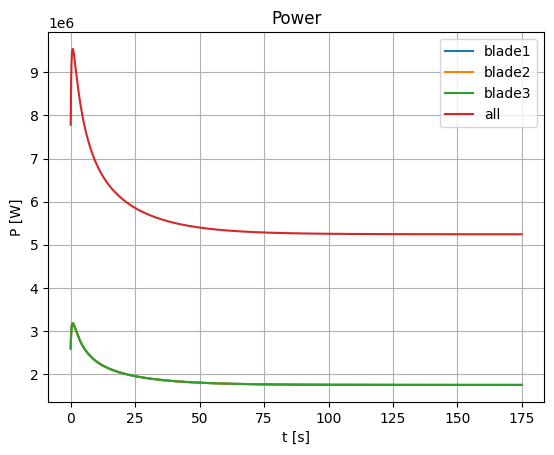

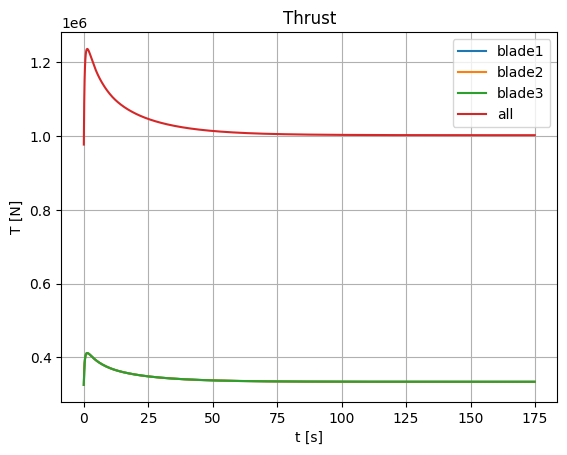

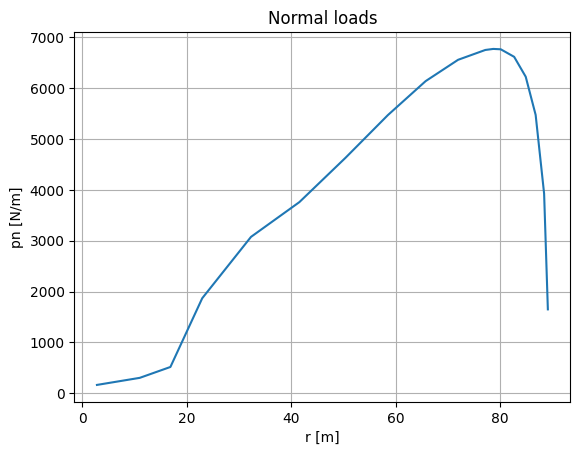

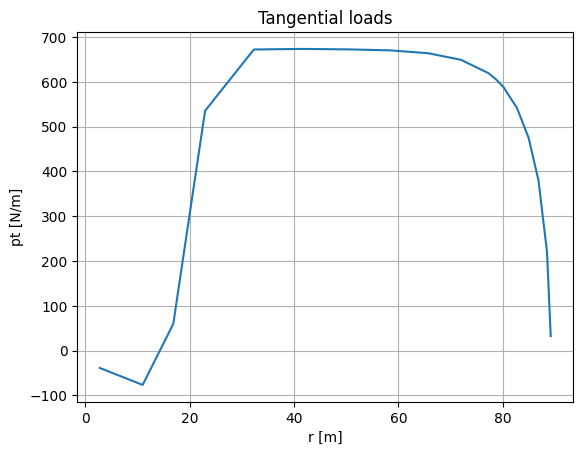

In [323]:
# Q1 plots

# powers (per blade)
plt.figure()
plt.plot(time_array, P[:,0], label='blade1')
plt.plot(time_array, P[:,1], label='blade2')
plt.plot(time_array, P[:,2], label='blade3')
plt.plot(time_array, (P[:,0]+P[:,1]+P[:,2]), label='all')
plt.grid()
plt.title('Power')
plt.xlabel('t [s]')
plt.ylabel('P [W]')
plt.legend()
plt.show()

# thrusts (per blade)
plt.figure()
plt.plot(time_array, T[:,0], label='blade1')
plt.plot(time_array, T[:,1], label='blade2')
plt.plot(time_array, T[:,2], label='blade3')
plt.plot(time_array, (T[:,0]+T[:,1]+T[:,2]), label='all')
plt.grid()
plt.title('Thrust')
plt.xlabel('t [s]')
plt.ylabel('T [N]')
plt.legend()
plt.show()

# normal loads (steady, per blade)
plt.figure()
plt.plot(r_array, pn)
plt.grid()
plt.title('Normal loads')
plt.xlabel('r [m]')
plt.ylabel('pn [N/m]')
plt.show()

# tangential loads (steady, per blade)
plt.figure()
plt.plot(r_array, pt)
plt.grid()
plt.title('Tangential loads')
plt.xlabel('r [m]')
plt.ylabel('pt [N/m]')
plt.show()

In [324]:
# Q2 calculation

# adding wind shear exponent
nu = 0.2

# adjusting simulation parameters
t_total = 175 # total time of simulation [s]
dt = 0.15 # time step size [s]
num = int(t_total / dt)+1 # number of time steps

# remove tower effect
a0 = 0

# constant zero pitch angle [rad]
theta_pitch = np.zeros(num)

P, T , time_array, pt, pn, W, pz_r_target = BEM()

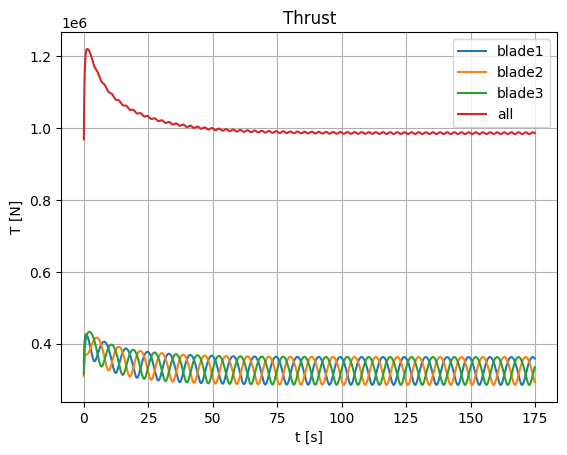

In [325]:
# Q2 plots

# thrusts (per blade)
plt.figure()
plt.plot(time_array, T[:,0], label='blade1')
plt.plot(time_array, T[:,1], label='blade2')
plt.plot(time_array, T[:,2], label='blade3')
plt.plot(time_array, (T[:,0]+T[:,1]+T[:,2]), label='all')
plt.grid()
plt.title('Thrust')
plt.xlabel('t [s]')
plt.ylabel('T [N]')
plt.legend()
plt.show()

In [326]:
# Q3 calculation

# removing wind shear effect
nu = 0

# adjusting simulation parameters
t_total = 200 # total time of simulation [s]
dt = 0.15 # time step size [s]
num = int(t_total / dt)+1 # number of time steps

# remove tower effect
a0 = 0

# pitch angle [rad]
theta_pitch = np.zeros(num)

for n in range(num):
    if n*dt < 100 or n*dt > 150:
        theta_pitch[n] = np.deg2rad(0)
    else:
        theta_pitch[n] = np.deg2rad(2)

P, T , time_array, pt, pn, W, pz_r_target = BEM()

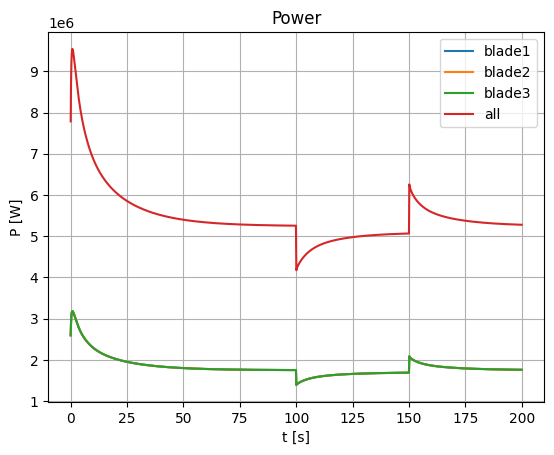

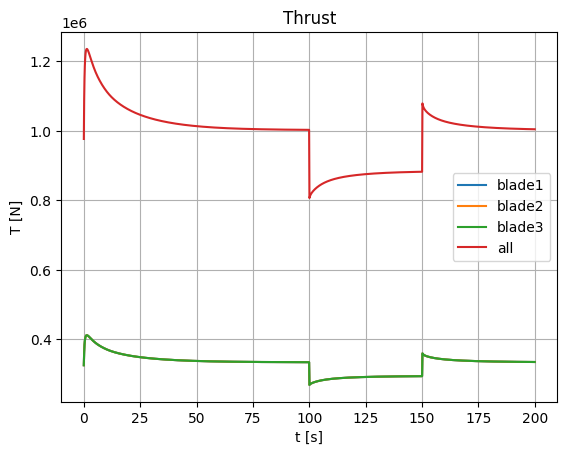

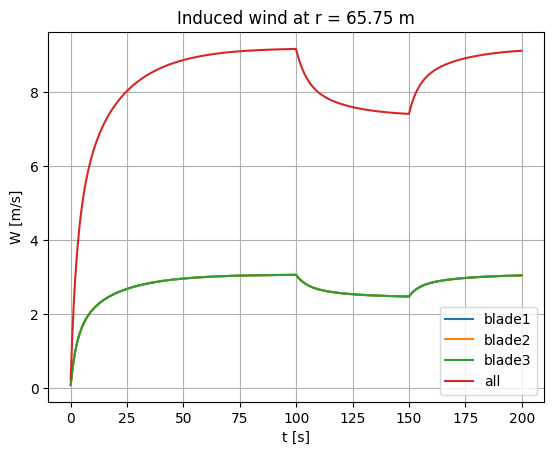

In [327]:
# Q3 plots

# powers (per blade)
plt.figure()
plt.plot(time_array, P[:,0], label='blade1')
plt.plot(time_array, P[:,1], label='blade2')
plt.plot(time_array, P[:,2], label='blade3')
plt.plot(time_array, (P[:,0]+P[:,1]+P[:,2]), label='all')
plt.grid()
plt.title('Power')
plt.xlabel('t [s]')
plt.ylabel('P [W]')
plt.legend()
plt.show()

# thrusts (per blade)
plt.figure()
plt.plot(time_array, T[:,0], label='blade1')
plt.plot(time_array, T[:,1], label='blade2')
plt.plot(time_array, T[:,2], label='blade3')
plt.plot(time_array, (T[:,0]+T[:,1]+T[:,2]), label='all')
plt.grid()
plt.title('Thrust')
plt.xlabel('t [s]')
plt.ylabel('T [N]')
plt.legend()
plt.show()

# induced winds (per blade)
plt.figure()
plt.plot(time_array, W[:,0], label='blade1')
plt.plot(time_array, W[:,1], label='blade2')
plt.plot(time_array, W[:,2], label='blade3')
plt.plot(time_array, (W[:,0]+W[:,1]+W[:,2]), label='all')
plt.grid()
plt.title('Induced wind at r = 65.75 m')
plt.xlabel('t [s]')
plt.ylabel('W [m/s]')
plt.legend()
plt.show()

In [329]:
# Q4 calculations

#Defining size of box
n1=8192
n2=64
n3=64

Lx=7371.9
Ly=180
Lz=180

umean=9

deltay=Ly/(n2-1)
deltax=Lx/(n1-1)
deltaz=Lz/(n3-1)
deltat=deltax/umean

time=np.arange(deltat, n1*deltat+deltat, deltat)

ushp_all = []

for i in range(1,4):
    file = "sim"+str(i)+".bin"

    # Load in the files and reshape them into 3D
    u = load(file,  N=(n1, n2, n3))
    ushp = np.reshape(u, (n1, n2, n3))
    ushp_all.append(ushp)

# fluctuations in CS1
fluc_z = ushp_all[0]
fluc_y = - ushp_all[1]
fluc_x = ushp_all[2]

y_sample = ( np.arange(0, Ly+deltay, deltay) - (Ly/2) ) * (-1)
x_sample = np.arange(0, Lz+deltaz, deltaz) - (Lz/2) + H

# removing wind shear effect
nu = 0

# adjusting simulation parameters
t_total = 500 # total time of simulation [s]
dt = deltat # time step size [s]
num = int(t_total / dt)+1 # number of time steps

# remove tower effect
a0 = 0

# pitch angle [rad]
theta_pitch = np.zeros(num)

P, T , time_array, pt, pn, W, pz_r_target = BEM(turb=True)

P_noturb, T_noturb , time_array_noturb, pt_noturb, pn_noturb, W_noturb, pz_r_target_noturb = BEM()

C:\Users\s232055\AppData\Local\Temp\ipykernel_8784\3550359839.py:189: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f_u = interp2d(y_sample, x_sample, fluc_x[n])
C:\Users\s232055\AppData\Local\Temp\ipykernel_8784\3550359839.py:190: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` in

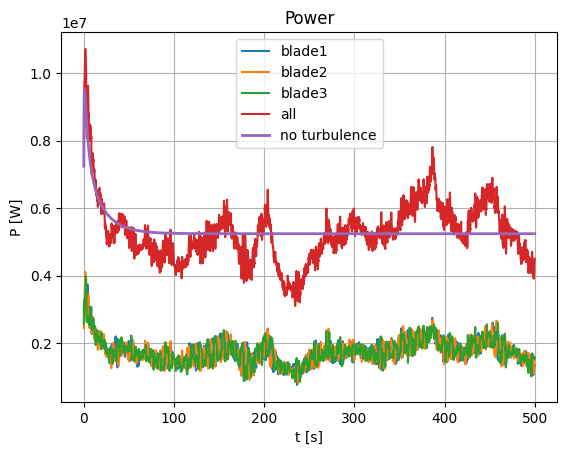

Difference between mean values with and without turbulence is 0.86%


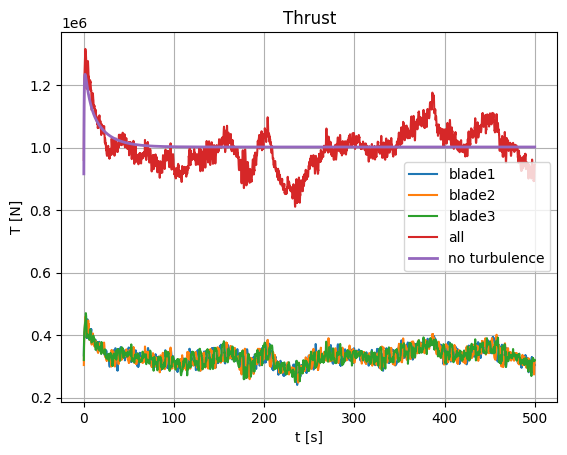

Difference between mean values with and without turbulence is 0.81%


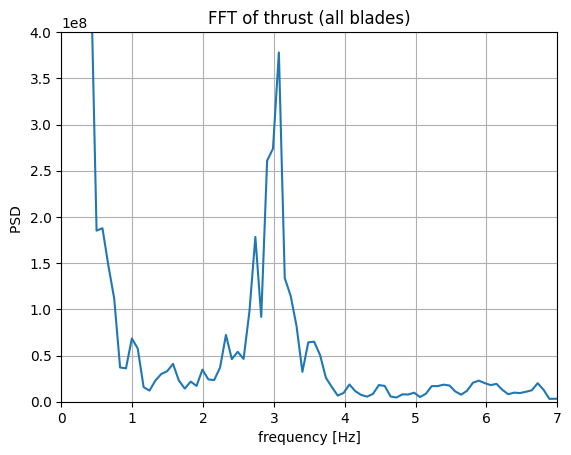

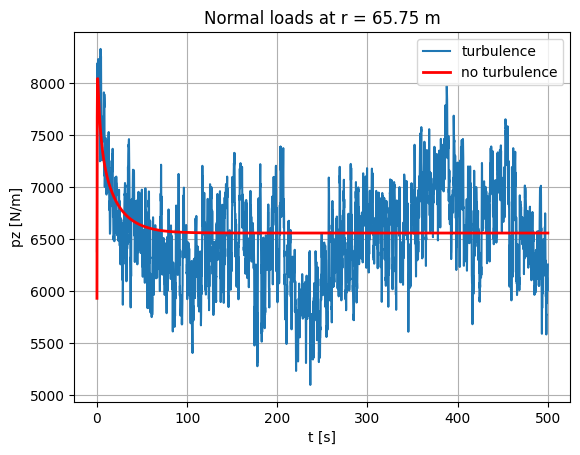

Difference between mean values with and without turbulence is 0.55%


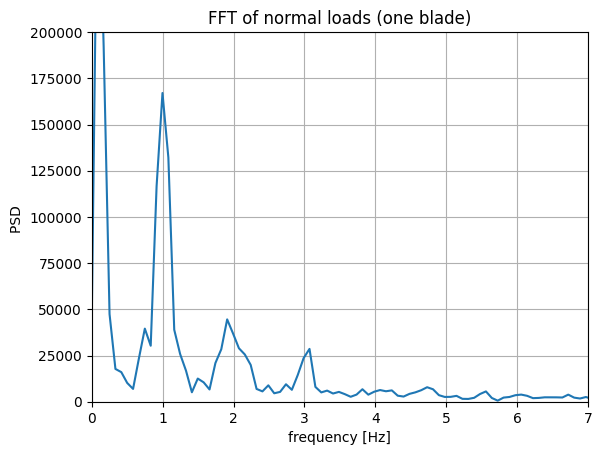

In [352]:
# Q4 results

# pz_avg = np.zeros(len(pz_r_target[:,0]))
# for i in range(len(pz_r_target[:,0])):
#     pz_avg[i] = np.mean(pz_r_target[:i, 0])

# powers (per blade)
plt.figure()
plt.plot(time_array, P[:,0], label='blade1')
plt.plot(time_array, P[:,1], label='blade2')
plt.plot(time_array, P[:,2], label='blade3')
plt.plot(time_array, (P[:,0]+P[:,1]+P[:,2]), label='all')
plt.plot(time_array, (P_noturb[:,0]+P_noturb[:,1]+P_noturb[:,2]), label='no turbulence', linewidth = 2)
plt.grid()
plt.title('Power')
plt.xlabel('t [s]')
plt.ylabel('P [W]')
plt.legend()
plt.show()

P_mean = np.mean(P[1000:,0]+P[1000:,1]+P[1000:,2])
P_noturb_mean = np.mean(P_noturb[1000:,0]+P_noturb[1000:,1]+P_noturb[1000:,2])
diff_P_mean = (P_mean - P_noturb_mean) /P_noturb_mean *100

print("Difference between mean values with and without turbulence is " + str(round(np.abs(diff_P_mean),2)) + "%")

# thrusts (per blade)
plt.figure()
plt.plot(time_array, T[:,0], label='blade1')
plt.plot(time_array, T[:,1], label='blade2')
plt.plot(time_array, T[:,2], label='blade3')
plt.plot(time_array, (T[:,0]+T[:,1]+T[:,2]), label='all')
plt.plot(time_array, (T_noturb[:,0]+T_noturb[:,1]+T_noturb[:,2]), label='no turbulence', linewidth = 2)
plt.grid()
plt.title('Thrust')
plt.xlabel('t [s]')
plt.ylabel('T [N]')
plt.legend()
plt.show()

T_mean = np.mean(T[1000:,0]+T[1000:,1]+T[1000:,2])
T_noturb_mean = np.mean(T_noturb[1000:,0]+T_noturb[1000:,1]+T_noturb[1000:,2])
diff_T_mean = (T_mean - T_noturb_mean) /T_noturb_mean *100

print("Difference between mean values with and without turbulence is " + str(round(np.abs(diff_T_mean),2)) + "%")

f, Pxx_den = signal.welch(T[1000:,0]+T[1000:,1]+T[1000:,2], fs = 2*np.pi /omega /deltat, nperseg=1000)
fig,ax=plt.subplots(1,1)
plt.plot(f, Pxx_den)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD ')
plt.title("FFT of thrust (all blades)")
plt.grid()
plt.xlim(0,7)
plt.ylim(0,0.4e9)
plt.show()

# normal load (per blade)
plt.figure()
plt.plot(time_array, pz_r_target[:,0], label='turbulence')
# plt.plot(time_array, pz_avg, label='averaged turbulence', linewidth = 2, linestyle='--')
plt.plot(time_array, pz_r_target_noturb[:,0], label='no turbulence', linewidth = 2, color='red')
plt.grid()
plt.title('Normal loads at r = 65.75 m')
plt.xlabel('t [s]')
plt.ylabel('pz [N/m]')
plt.legend()
plt.show()

pz_mean = np.mean(pz_r_target[1000:,0])
pz_noturb_mean = np.mean(pz_r_target_noturb[1000:,0])
diff_pz_mean = (pz_mean - pz_noturb_mean) /pz_noturb_mean *100

print("Difference between mean values with and without turbulence is " + str(round(np.abs(diff_pz_mean),2)) + "%")

f, Pxx_den = signal.welch(pz_r_target[1000:,0], fs = 2*np.pi /omega /deltat, nperseg=1000)
fig,ax=plt.subplots(1,1)
plt.plot(f, Pxx_den)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD ')
plt.title("FFT of normal loads (one blade)")
plt.grid()
plt.xlim(0,7)
plt.ylim(0,0.2e6)
plt.show()